# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2016

# Datos de la entrega

** Número de Grupo: 14**

<div style="float:left;margin-right:10px;"><b>Integrantes:</b></div>
<div style="float:left;width:50%;">
    Guzmán Oholeguy (CI 4.799.173-5) <br>
    Facundo Parodi (CI 4.940.436-2) <br>
    Camila Rosso (CI 4.530.414-0)
</div>

## Importación de las sentencias del corpus del Poder Judicial.

Se comienza por cargar las sentencias desde el archivo *corpus_pj.csv* otorgado junto a la letra del presente laboratorio.

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import IPython.display as disp

# Carga del corpus de sentencias del Poder Judicial
# Se eliminan las filas duplicadas y se toman, además de la columna 'sentencia',
# 5 otras utilizadas por el seleccionador de sentencias
corpus = pd.read_csv("corpus_pj.csv", delimiter=',', skip_blank_lines=True, encoding='utf-8')
rows, cols = corpus.shape

disp.HTML("El corpus contiene " + str(rows) + " filas y " + str(cols) +" columnas")

## Análisis y limpieza del corpus

Dado que se trabajará sobre la columna **sentencia**, se decidió observar si el corpus contenía valores repetidos en dicha columna. La siguiente celda indica que en efecto existen 51 sentencias repetidas.

Realizando algunas pruebas sobre sentencias, se detectó además que existen sentencias idénticas a excepción del número de espacios que separan algunas palabras. Dado que el proceso de tokenización en general ignora más de un espacio sucesivo, se decidió limpiar las sentencias eliminando los espacios que las rodean, así como reemplazar conjuntos de espacios por uno único. Esto permitió descartar 8 sentencias más.

Como el proceso de anotación procesaría exactamente de la misma forma dos frases idénticas, se decidió eliminarlas del corpus. Esto redujo la cantidad de filas de 20047 a 19988 (59 sentencias repetidas).<br>
Además, la columna **resumen** es descartada dado que no se utiliza a lo largo de la tarea.

In [2]:
# Diferencia entre la cantidad de filas del corpus original y la cantidad de sentencias no repetidas
diff = rows - len(corpus["sentencia"].unique())
out = ""
if diff:
    out = "<b>El corpus presenta " + str(diff) + " sentencias repetidas</b>"
else:
    out = "<b>No se encontraron sentencias repetidas</b>"
disp.HTML(out)

In [3]:
import re

# Función que elimina los espacios rodeando un string, y reemplaza secuencias de espacios por uno solo
def cleanString(s):
    s = str(s)
    s = s.strip()
    return re.sub("\s+", ' ', s)

# Se seleccionan las columnas de interés
corpus = corpus[["sentencia", "importancia", "tipo", "numero", "sede", "procedimiento", "fecha", "ficha"]]
# Se aplica la función de limpieza a todo el corpus
corpus = corpus.applymap(cleanString)

# Se eliminan aquellas filas que repitan una sentencia
corpus.drop_duplicates(["sentencia"],inplace = True)

# Diferencia entre la cantidad de filas del corpus original y la cantidad de sentencias no repetidas
diff = rows - len(corpus["sentencia"].unique())
out = ""
if diff:
    out = "<b>El corpus presenta " + str(diff) + " sentencias repetidas</b>"
else:
    out = "<b>No se encontraron sentencias repetidas</b>"
disp.HTML(out)

In [4]:
corpus.describe()

,sentencia,importancia,tipo,numero,sede,procedimiento,fecha,ficha
count,19988,19988,19988,19988,19988,19988,19988,19988
unique,19988,3,2,5309,16,27,1218,16875
top,"Sentencia N 86, ,Montevideo,26 de marzo de 200...",ALTA,DEFINITIVA,100/2007,Suprema Corte de Justicia,PROCESO CIVIL ORDINARIO,26/03/2008,Sin datos
freq,1,10008,12780,17,3795,7455,111,1881


La tabla anterior presenta un resumen del corpus una vez limpiado. Para cada una de las columnas, las filas indican:

<ul>
    <li>**count:** Cantidad de valores no vacíos</li>
    <li>**unique:** Cantidad de valores no repetidos</li>
    <li>**top:** Valor más frecuente</li>
    <li>**freq:** Frecuencia del valor más común</li>
</ul>

Como puede observarse, ninguna columna presenta valores vacíos, y como es esperable, todas las sentencias son únicas.

Aproximadamente la mitad de las sentencias son clasificadas como de importancia ALTA, el 64% como tipo DEFINITIVA, el 19% fueron llevadas a cabo en la Suprema Corte de Justicia, el 37% correponden a un PROCESO CIVIL ORDINARIO, y un 9.4% no indica a qué ficha pertenecen.

A continuación pueden observarse un conjunto de gráficas mostrando la distribución de sentencias según **importancia**, **tipo**, **sede** y **procedimiento**. No se realizó una separación por **numero**, **fecha** o **ficha** debido a la gran cantidad valores diferentes que presentan.

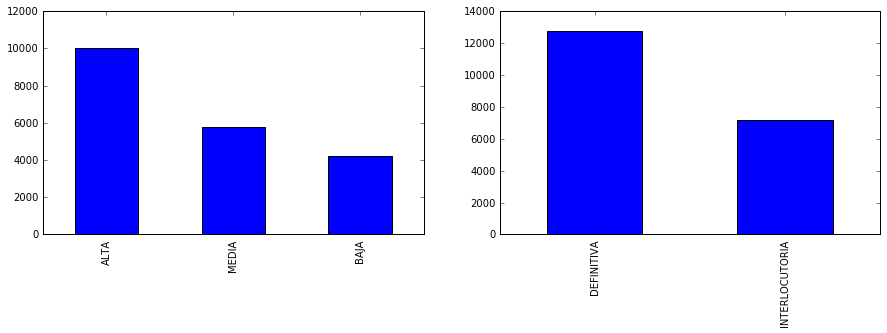

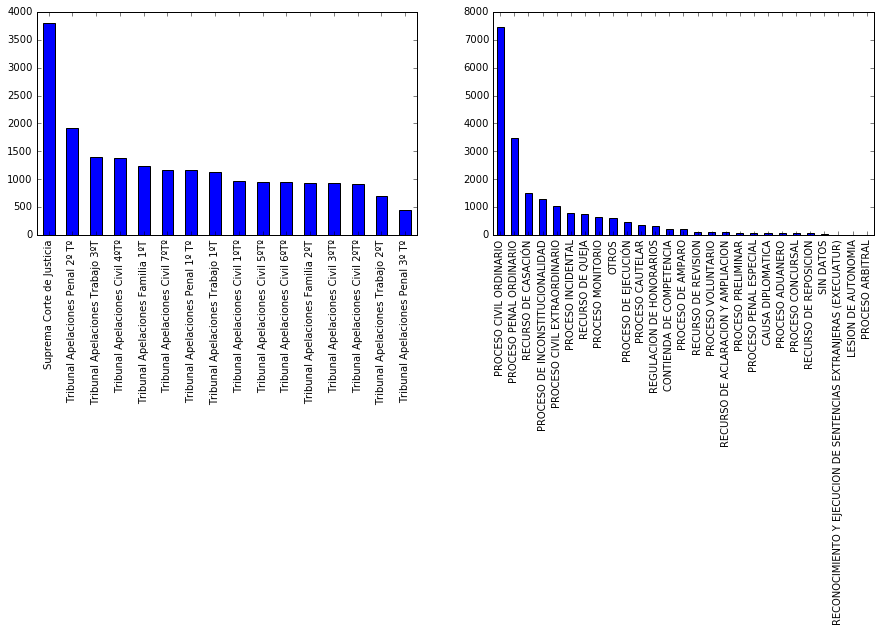

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

imp=corpus['importancia'].astype('category').value_counts()
tipo=corpus['tipo'].astype('category').value_counts()
sede=corpus['sede'].astype('category').value_counts()
proc=corpus['procedimiento'].astype('category').value_counts()

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
imp.plot(kind='bar', ax = axs[0])
tipo.plot(kind='bar', ax = axs[1])

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sede.plot(kind='bar', ax = axs[0])
proc.plot(kind='bar', ax = axs[1])

### Estudio de los tokens

Dado que se va a extraer información de los tokens de cada sentencia para poder analizarlos, se decidió estudiar la distribución de estos a lo largo del corpus.

La celda siguiente presenta la cantidad de tokens de la frase más corta y más larga, así como la cantidad de tokens total y únicos en todo el corpus. Como es un proceso lento, el código imprime un mensaje cada 500 sentencias analizadas para dar a conocer su progreso, y al final los datos calculados. Para extraer los tokens de una sentencia se utilizó la función *word_tokenize* de NLTK.

In [6]:
import nltk
from math import sqrt

sentences = corpus["sentencia"]

# Se analiza la primer sentencia del corpus aparte, para poder inicializar los valores de mínimo y máximo
sentence = sentences.iloc[0]
tokens = nltk.word_tokenize(sentence)
uniqueTokens = set(tokens)
count = len(tokens)
maxT = count
posmaxT = 0
minT = count
posminT = 0
tokensTotal = 0
n = 1
mean = count
M2 = 0.0

# Se analizan las sentencias de a 500 para poder imprimir progreso
for i in range(0, (len(sentences) - 1)//500):
    print("Procesados hasta el " + str(n-1), flush=True)
    for j in range(0, 500):
        sentence = sentences.iloc[n]
        
        # Tokenización de la sentencia
        tokens = nltk.word_tokenize(sentence)
        # Actualización del conjunto de tokens únicos
        uniqueTokens = uniqueTokens.union(set(tokens))
        count = len(tokens)
        
        # Cálculo del máximo y mínimo número de tokens por sentencia
        if (count > maxT):
            posmaxT = n
            maxT = count
        if (count < minT):
            posminT = n
            minT = count
        # Cálculo del total de tokens en el corpus
        tokensTotal = tokensTotal + count
        
        # Cálculo incremental del promedio y desviación estandar de la cantidad de tokens por sentencia
        n = n + 1
        delta = count - mean
        mean = mean + delta/n
        M2 = M2 + delta*(count - mean)

# El último bloque de sentencias puede no ser de 500 y se procesa aparte
print("Procesados hasta el " + str(n-1), flush=True)
for i in range(n, len(sentences)):
    sentence = sentences.iloc[n]
    tokens = nltk.word_tokenize(sentence)
    uniqueTokens = uniqueTokens.union(set(tokens))
    count = len(tokens)
    
    if (count > maxT):
        posmaxT = n
        maxT = count
    if (count < minT):
        posminT = n
        minT = count
    tokensTotal = tokensTotal + count
    
    n = n + 1
    delta = count - mean
    mean = mean + delta/n
    M2 = M2 + delta*(count - mean)

M2 = sqrt(M2 / (n - 1))

print("Proceso completado\n\n")

print("Cantidad total de tokens: " + str(tokensTotal))
print("Cantidad de tokens únicos: " + str(len(uniqueTokens)))
print("Promedio de tokens por sentencia: " + str(mean))
print("Desviación estándar: " + str(M2) + "\n")

print("Sentencia con la máxima cantidad de tokens: \n")
print(corpus.iloc[posmaxT])
print("\nTiene " + str(maxT) + " tokens y se corresponde con la fila " + str(corpus.iloc[posmaxT].name + 2) + " del corpus\n\n")

print("Sentencia con la mínima cantidad de tokens: \n")
print(corpus.iloc[posminT])
print("\nTiene " + str(minT) + " tokens y se corresponde con la fila " + str(corpus.iloc[posminT].name + 2) + " del corpus\n\n")

Procesados hasta el 0
Procesados hasta el 500
Procesados hasta el 1000
Procesados hasta el 1500
Procesados hasta el 2000
Procesados hasta el 2500
Procesados hasta el 3000
Procesados hasta el 3500
Procesados hasta el 4000
Procesados hasta el 4500
Procesados hasta el 5000
Procesados hasta el 5500
Procesados hasta el 6000
Procesados hasta el 6500
Procesados hasta el 7000
Procesados hasta el 7500
Procesados hasta el 8000
Procesados hasta el 8500
Procesados hasta el 9000
Procesados hasta el 9500
Procesados hasta el 10000
Procesados hasta el 10500
Procesados hasta el 11000
Procesados hasta el 11500
Procesados hasta el 12000
Procesados hasta el 12500
Procesados hasta el 13000
Procesados hasta el 13500
Procesados hasta el 14000
Procesados hasta el 14500
Procesados hasta el 15000
Procesados hasta el 15500
Procesados hasta el 16000
Procesados hasta el 16500
Procesados hasta el 17000
Procesados hasta el 17500
Procesados hasta el 18000
Procesados hasta el 18500
Procesados hasta el 19000
Procesados



Se observa que si bien el corpus cuenta con poco más de 30 millones de tokens, únicamente 331.000 son distintos (aproximadamente 1.1%). Este sigue siendo un número muy elevado tomando en cuenta que el Diccionario de la Lengua Española de la Real Academia Española edición 2014 contiene alrededor de 93.000 lemas (http://www.rae.es/diccionario-de-la-lengua-espanola/presentacion). Si bien un token no representa un lema, sino que podrían ser verbos conjugados, palabras en plural, puntuación, entre otros, tampoco es usual utilizar una porción muy grande del léxico del idioma. De todas formas, es posible explicar dicha cantidad por la cantidad de tokens numéricos que estos textos presentan: montos monetarios, fechas, números de ficha, etc.

Una sentencia promedio del corpus presenta unos 1500 tokens, con una desviación estándar de 1241, lo que indica que existe este número varía significativamente a lo largo del corpus. De hecho, la sentencia más corta y más larga están compuestas de 2 y 36296 tokens cada una. La más corta se corresponde con la fila 17619 del archivo *.csv*, y el texto es "Sin datos".

## Configuración de FreeLing

FreeLing es una biblioteca escrita en C++ que provee herramientas para análisis morfológico, detección de entidades con nombre, tokenización, desambiguación, entre otras, para un conjunto amplio de lenguajes, entre ellos Español. Los autores proveen un ejecutable que permite interactuar con la biblioteca, pero esta puede ser llamada directamente si se agrega al proyecto. Como está escrita en C++, se debe utilizar un *wrapper* que permita acceder a las funcionalidades desde Python.

El código fuente necesario para compilar el *wrapper* puede encontrarse en la página de GitHub de FreeLing, más específicamente: https://github.com/iknow/FreeLing/tree/master/APIs/python. Se deben configurar las variables **FREELINGDIR** y **PYTHONDIR** en el archivo *Makefile* con las rutas correspondientes al directorio de instalación de FreeLing, y de Python respectivamente. En la computadora que se utilizó durante el desarrollo de este trabajo, estas se corresponden con:

<pre>
    FREELINGDIR = /usr/share
    PYTHONDIR = /usr/include/python3.5
</pre>

Una vez configurado el Makefile se puede compilar el *wrapper* con el programa **make**, generando los archivos *freeling.py* y *_freeling.so*. Luego se puede incluir a FreeLing en el notebook ejecutando **import freeling** (teniendo los archivos mencionados en el mismo directorio que el notebook). Para simplificar el trabajo, se adjuntan estos dos archivos junto al notebook.

## Configuración de las herramientas de FreeLing

Todas las herramientas de FreeLing necesitan un archivo de configuración con las reglas e información necesarias para poder procesar la entrada, ya sea un bloque de texto, una sentencia, una palabra, etc. FreeLing brinda un conjunto de archivos de configuración para varios idiomas, entre ellos el Español. Estos están conmunmente ubicados en un directorio por defecto, el cual puede variar dependiendo de la forma en que se haya instalado la herramienta, así como también del sistema operativo. La máquina utilizada para realizar las pruebas contenía estos archivos en el directorio **/usr/share/freeling/es**. La celda siguiente define las variables **FREELINGDIR**, **DATA** y **LANG** que permiten fácilmente adaptar el código para ejecutar en un entorno donde freeling se encuentre en otro directorio.

Se utilizaron 5 herramientas: un tokenizador, un separador, un analizador morfolólogico, un etiquetador y un clasificador de entidades con nombre. A continuación se presenta cada una de ellas, indicando además cómo se configuraron.

<h3>Tokenizador <i>(tokenizer)</i></h3>

Esta herramienta toma un texto como entrada y lo separa en tokens (componentes léxicos), siguiendo un conjunto de reglas escritas como expresiones regulares. FreeLing proporciona un juego de reglas para el Español en el archivo *tokenizer.dat*.

<h3>Separador <i>(splitter)</i></h3>

El separador toma la lista de tokens generada por el tokenizador y los agrupa en sentencias. Nuevamente, FreeLing provee un archivo de configuración (*splitter.dat*) que contiene entre otras cosas, marcadores de fin de sentencia como *?* o *!*.

<h3>Analizador morfológico</h3>

Esta herramienta engloba un conjunto de módulos que procesan las sentencias y palabras de entradas, pudiendo habilitar y deshabilitar aquellos que se deseen convenientes. En el presente trabajo se utilizaron:

<ul>
    <li><b>Detección de puntuación:</b> este módulo etiqueta aquellos tokens que reconoce como símbolos de puntuación. El archivo que contiene los símbolos más comunes es *common/punct.dat*</li>
    <li><b>Detección de números:</b> reconoce expresiones numéricas y les asigna un valor normalizado. Este módulo es dependiente del lenguaje, ya que los símbolos de separación de miles y de decimales difiere por ejemplo, entre el idioma Español y el Inglés. Este módulo reconoce a la expresion "dos mil siete" como un unico numero asignandole el lemma 2007.</li>
    <li><b>Detección de fechas:</b> reconoce secuencias de tokens que representan fechas. Al igual que el módulo de detección de números, es dependiente del lenguaje. FreeLing decide automáticamente qué reglas utilizar en función del lenguaje configurado. Este reconoce las fechas asignándoles como lemma la fecha en formato [w:DD/MM/YYYY:hh.mm:tt] y como tag W por ejemplo "9 de agosto de 2006" lo reconoce como una única entidad con lemma [??:9/8/2006:??.??:??]. Dado que en el formato CONLL-U no se tiene una especificación para las fechas, se decidió realizar el análisis de las fechas de forma que analice cada token por separado.
    <li><b>Búsqueda de diccionario:</b> este módulo se encarga de buscar los tokens en un diccionario que contiene tanto el lema de la palabra como su etiqueta. Para aquellas palabras que no se encuentren en el diccionario, aplica un conjunto de reglas que le permiten buscar otras palabras que puedan tener dicha información. Por ejemplo, es posible que la palabra <b>casas</b> no se encuentre en el diccionario, pero puede buscarse el singular <b>casa</b>. Para la configuración de este módulo se utiliza el archivo *dicc.src*.</li>
    <li><b>Reconocimiento de <i>multi-palabras</i>:</b> este módulo reconoce secuencias de palabras que forman un grupo con sentido, y genera una nueva palabra resultante de su combinación. Ejemplos de esto son las secuencias <b>a través de</b> o <b>a buenas horas</b>. El archivo de configuración utilizado es *locucions.dat*. Este módulo se utilizó en conjunto con el siguiente para realizar el reconocimiento de entidades con nombre con Freeling, pero al realizar esta tarea con NLTK y scikit-learn se deshabilitan ambos módulos.</li>
    <li><b>Reconocimiento de entidades con nombre:</b> reconoce entidades o nombres propios. FreeLing tiene dos tipos de módulos capaces de realizar esta tarea, un reconocedor basado en *redes de transición aumentadas*, y otro basado en técnicas de aprendizaje automático. Según los desarrolladores de FreeLing, el primero es más veloz pero presenta una tasa del 85% de entidades reconocidas correctamente, mientras que el último sobrepasa el 90%. Para esta tarea se trabajó con el módulo de aprendizaje automático, por lo que se utilizó el archivo de configuración *nerc/ner/ner-ab-rich.dat*.</li>
    <li><b>Asignador de probabilidades y *adivino* de palabras:</b> tiene dos funciones: asignar probabilidades a las etiquetas de cada palabra, y asignar un conjunto de posibles etiquetas a aquellas palabras que no pudieron ser etiquetadas por módulos anteriores basándose en la terminación de las mismas. Se utiliza el archivo de configuración *probabilitats.dat*.</li>
</ul>

<h3>Etiquetador *(Part-of-Speech Tagger)*</h3>

Esta herramienta asigna una etiqueta gramatical a cada palabra de una sentencia, utilizando la información obtenida por las herramientas explicadas anteriormente. FreeLing ofrece dos módulos, *hmm_tagger* basado en cadenas de Markov ocultas, y *relax_tagger* que permite corregir el modelo agregando restricciones manuales. Este último presenta demoras de más del doble de tiempo que el primero, por lo que se eligió *hmm_tagger*. El archivo de configuración para esta herramienta es *tagger.dat*.

<h3>Clasificador de entidades con nombre *(Named Entity Classification)*</h3>

Esta herramienta asigna una clase a cada entidad con nombre reconocida en una sentencia. Trabaja con 4 clases: **Persona**, **Organización**, **Ubicación geográfica** y **Otras**. Es un módulo basado en aprendizaje automático, y FreeLing ofrece un clasificador ya entrenado para idioma Español en el archivo *nerc/nec/nec-ab-rich.dat*.

In [7]:
import freeling as fl

# Configuración de las rutas de instalacion de FreeLing
# y el lenguaje a utilizar (en este caso, español)
FREELINGDIR = "/usr"
DATA = FREELINGDIR+"/share/freeling/"
LANG="es"

fl.util_init_locale("default");

# Inicialización del tokenizer y splitter
tk = fl.tokenizer(DATA + LANG + "/tokenizer.dat");
sp = fl.splitter(DATA + LANG + "/splitter.dat");
sid = sp.open_session()

# Configuración del analizador morfológico
op = fl.maco_options("es");

op.PunctuationFile=DATA + "/common/punct.dat"
op.DictionaryFile=DATA + LANG + "/dicc.src"
op.AffixFile=DATA + LANG + "/afixos.dat"
op.LocutionsFile=DATA + LANG + "/locucions.dat"
op.QuantitiesFile=DATA + LANG + "/quantities.dat"
op.NPdataFile=DATA + LANG + "/nerc/ner/ner-ab-rich.dat"
op.ProbabilityFile=DATA + LANG + "/probabilitats.dat"
op.CompoundFile=DATA + LANG + "/compounds.dat"
op.ProbabilityThreshold = 0.001

# Inicialización del analizador morfológico y el POS-tagger
mf = fl.maco(op)
mf.set_active_options(
    False, #umap
    True,  #num
    True,  #pun
    False, #dat
    True,  #dic
    True,  #aff
    True,  #comp
    False, #rtk
    False, #mw
    False, #ner
    True,  #qt
    True   #prb
)
tg = fl.hmm_tagger(DATA + LANG + "/tagger.dat", False, 1)

## Reconocimiento de entidades con nombre

Para el reconocimiento de las entidades con nombre se utilizó en primera instancia Freeling con los módulos del analizador morfológico y el clasificador de entidades con nombre de Freeling nombrados anteriormente. A partir de esto obtuvimos ciertos problemas con el etiquetado de los tokens multi-palabra, por lo cual se pasó a probar realizando el NER con un clasificador entrenado a partir del corpus *conll2002* en Español con NLTK y una herramienta externa que utiliza CRF (Conditional Random Field).

Luego de probados ambos clasificadores (Freeling y el clasificador basado en CRF), observamos ciertas mejoras en algunas clasificaciones, como por ejemplo “Tribunal de Apelaciones”. Freeling lo clasifica como LOC, mientras que el otro lo clasifica como ORG, siendo esta segunda más acertada. 

### Clasificador entrenado a partir de conll2002 y CRF

Este clasificador funciona de forma tal que luego de que Freeling realiza el etiquetado de los tokens, el clasificador recibe cada token de una oración acompañado de su correspondiente etiqueta (obtenida a partir de Freeling). El clasificador devuelve para cada uno de los tokens de la oración su clasificación, ya teniendo la información de si es el primer token de la entidad (B) o está dentro de una (I).

El corpus *conll2002* está divido por defecto en sentencias de entrenamiento y sentencias de testing. Estas sentencias fueron ajustadas para que el entrenamiento sea únicamente con las clasificaciones O, LOC, ORG y PER, descartando la clasificación MISC que refiere a una clasificación variada. Por ejemplo, al entrenar el clasificador con el corpus, el grupo nominal “Sra. Juez Letrado de Primera Instancia del Chuy” lo reconoció como un MISC (lo que puede deberse a que es una entidad PER en conjunto con una entidad LOC), en cambio descartando esta clasificación lo reconoció como organización.

### Entrenamiento

El entrenamiento del clasificador se realiza utilizando CRF, CRF es un modelo que presenta similitudes con los modelos ocultos de Márkov (Hmm). CRF modela la probabilidad de la secuencia correcta de etiquetas $S = (t_1, \dots{}, t_n)$ dado un conjunto de observaciones $O = (o_1, \dots{}, o_n)$, es decir $P(S \vert O)$. Para el entrenamiento se extrae un conjunto de características (features) asignándoles distintos pesos para indicar la relevancia de cada una de ellas, en base a estas características se obtienen las dependencias entre los diferentes estados y la secuencia de observaciones. 

### Configuración

Para el entrenamiento del clasificador se debe instalar el scikit-learn, en la computadora que se utilizó se instaló mediante los comandos: 
<pre>
conda install scikit-learn
pip install sklearn-crfsuite
</pre>
Para descargar el corpus *conll2002* se puede utilizar el comando *nltk.download()* y seleccionarlo de la lista de corpora disponible.

In [8]:
#Este código se hizo en base a 
#http://nbviewer.jupyter.org/github/tpeng/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb

from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import pycrfsuite

#Sentencias de entrenamiento de conll2002 para el español
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
#Sentencias de testing de conll2002 para el español
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

#Ajustar sentencias de testing para no conciderar la clasificacion MISC 
n_test_sents = []


for sent in test_sents:
    n_sent = []
    for token, postag, label in sent:
        if label != "B-MISC" and label != "I-MISC":
            n_sent = n_sent + [(token, postag, label)]
    n_test_sents = n_test_sents + [n_sent]

test_sents = n_test_sents  


#Ajustar sentencias de entrenamiento para no conciderar la clasificacion MISC 
n_train_sents = []
    
for sent in train_sents:
    n_sent = []
    for token, postag, label in sent:
        if label != "B-MISC" and label != "I-MISC":
            n_sent = n_sent + [(token, postag, label)]
    n_train_sents = n_train_sents + [n_sent]

train_sents = n_train_sents 

#Caracteristicas utilizadas para el entrenamiento 

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

# Se aplican las caracteristicas sobre el corpus

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


# Se crea el entrenador y se cargan los datos de entrenamiento

trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# Se selecciona los parametros de entrenamiento 
    
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

# Se entrena el modelo
trainer.train('conll2002-esp.crfsuite')

# Se guarda el modelo
!ls -lh ./conll2002-esp.crfsuite

# Se crea el tagger en base al modelo
tagger = pycrfsuite.Tagger()
tagger.open('conll2002-esp.crfsuite')

/home/tecno_1994/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tecno_1994/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


-rw-r--r-- 1 tecno_1994 tecno_1994 336K Nov 30 19:53 ./conll2002-esp.crfsuite


### Evaluación

A continuacion se realiza la evaluacion del clasificador entrenado. Para esto se utiliza las sentencias de testing obtenidas a partir del corpus Conll2002 y se ejecuta el clasificador sobre estas sentencias. Luego se compara la salida del clasificador con la salida esperada y en base a esta comparación se obtiene una tabla con datos cuantitativos por cada clasificación existente.
Se observa que los resultados obtenidos del análisis de las sentencias de entrenamiento están en promedio sobre el 80%.

In [9]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

def bio_classification_report(y_true, y_pred):
    """
    Classification report for a list of BIO-encoded sequences.
    It computes token-level metrics and discards "O" labels.
    
    Note that it requires scikit-learn 0.15+ (or a version from github master)
    to calculate averages properly!
    """
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )


y_pred = [tagger.tag(xseq) for xseq in X_test]
print(bio_classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      B-LOC       0.79      0.77      0.78      1084
      I-LOC       0.66      0.61      0.63       325
      B-ORG       0.85      0.82      0.83      1400
      I-ORG       0.88      0.84      0.86      1104
      B-PER       0.82      0.88      0.85       735
      I-PER       0.89      0.94      0.91       634

avg / total       0.83      0.82      0.83      5282



## Selección de sentencias del corpus

Para la selección de una sentencia se decidió utilizar el resto de la información del archivo *.csv*, y de esta forma poder filtrar las sentencias en función de los valores de las demás columnas.
Con el objetivo de hacer amigable la interfaz, se utilizó el paquete ipywidgets que permite agregar un diverso conjunto de herramientas visuales como menúes *dropdown*, campos de texto, selectores de opciones, listas, deslizadores, entre otros. En caso de no contar con este paquete, se puede instalar ejecutando los comandos:

<pre>
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
</pre>

Se utilizan 7 filtros, uno por cada columna aparte de **sentencia**. Con la excepción del filtro de fecha, todos son menúes *dropdown* que permiten seleccionar un elemento. Los valores disponibles de un filtro se actualizan en función de la selección de los demás, de forma de ayudar a seleccionar combinaciones de filtros siempre válidas. El selector de **fecha** es un cuadro de texto que espera la entrada en formato *DD/MM/YYYY*, y descarta cualquier entrada que no lo cumpla. Todos los filtros aceptan la opción "Todos" que indica que cualquier valor es aceptado para dicho campo.

Dado que se controla que los valores de los filtros sean válidos, siempre se cuenta con un subconjunto no vacío de sentencias seleccionadas. La primera de ellas se utiliza para ser analizada.

Tomando en cuenta el gran número de valores posibles para los campos **ficha** y **numero**, se aconseja filtrar por las demás columnas para obtener una lista reducida de campos. 

In [10]:
# Esta celda se utiliza para seleccionar una frase del corpus a ser analizada
# Permite filtrar las filas del archivo por Importancia, Tipo, Procedimiento, Sede y Número,
# actualizando automáticamente las opciones de los filtros para que la combinación de los
# mismos sea coherente con los datos del corpus
from ipywidgets import interact, interactive, fixed, Dropdown, Text
import re

filteredCorpus = corpus

# Función que actualiza las opciones de los filtros
# Se selecciona para cada filtro aquellas opciones que se encuentran en el corpus filtrado hasta el momento,
# evitando así combinaciones de filtros incoherentes
def updateWidgets():
    for k, v in widgets.items():
        if k != "fecha":
            # Para cada filtro se toman los valores distintos de la columna correspondiente
            opts = filteredCorpus[k].unique().tolist()
            opts.sort()
            # Se agrega la opción 'Todos' si no se quiere aplicar dicho filtro
            v.options = ["Todos"] + opts

# Definición inicial de los filtros con opciones vacías
widgets = {"importancia":Dropdown(description = "Importancia: "),
           "tipo":Dropdown(description = "Tipo: "),
           "numero":Dropdown(description = "Número: "),
           "procedimiento":Dropdown(description = "Procedimiento: "),
           "sede":Dropdown(description = "Sede: "),
           "ficha":Dropdown(description = "Ficha: "),
           "fecha":Text(placeholder = "DD/MM/YYYY", description = "Fecha: ")}

# Se llama a la función updateWidgets para popular los filtros con las opciones válidas del corpus
updateWidgets()

# Selecciones por defecto: no se aplica ningún filtro
options = {"importancia":"Todos",
           "tipo":"Todos",
           "numero":"Todos",
           "procedimiento":"Todos",
           "sede":"Todos",
           "fecha":"Todos",
           "ficha":"Todos"}

# Función que aplica los filtros seleccionados al corpus
# Actualiza la variable options con las nuevas opciones seleccionadas y la variable
# filteredCorpus con aquellas filas del corpus que cumplen con los filtros
def applyFilters(numero, procedimiento, sede, importancia, tipo, fecha, ficha):
    global filteredCorpus
    global options
    # Diccionario que mantiene las nuevas opciones seleccionadas
    if not re.match("\d\d/\d\d/\d\d\d\d", fecha):
        fecha = "Todos"
    newOptions = {"importancia":importancia,
                  "tipo":tipo,
                  "numero":numero,
                  "procedimiento":procedimiento,
                  "sede":sede,
                  "fecha":fecha,
                  "ficha":ficha}
    # Se busca el filtro que realizó el cambio
    changed = None
    for k, v in newOptions.items():
        if v != options[k]:
            changed = k

    # Si algún filtro fue cambiado se procede a actualizar la variable filteredCorpus
    if changed:
        # Si la opción cambió de 'Todos' a otro valor más específico, no es necesario reaplicar todos los filtros
        if options[changed] == "Todos":
            filteredCorpus = filteredCorpus[filteredCorpus[changed] == newOptions[changed]]
        # Si se cambió un filtro a otra opción, o se desactivó con la opción 'Todos',
        # se deben reaplicar todos los filtros sobre el corpus original
        else:
            filteredCorpus = corpus
            for k, v in newOptions.items():
                # Se aplican los filtros que no tienen la opción 'Todos' seleccionada
                if v != "Todos":
                    filteredCorpus = filteredCorpus[filteredCorpus[k] == v]
        # Se actualiza el diccionario de opciones y las opciones de los filtros
        options[changed] = newOptions[changed]
        updateWidgets()

# Instanciación de los menúes dropdown que permiten seleccionar las opciones de los filtros
interact(applyFilters, fecha = widgets["fecha"],
                       ficha = widgets["ficha"],
                       numero = widgets["numero"],
                       procedimiento = widgets["procedimiento"],
                       sede = widgets["sede"],
                       tipo = widgets["tipo"],
                       importancia = widgets["importancia"])

## Análisis de la sentencia

Luego de seleccionada la sentencia con los filtros anteriores, se procede a ejecutar el análisis de la misma. Se comienza por separar el texto en tokens usando el tokenizador de FreeLing, luego se agrupan en sentencias, se ejecuta el analizador morfológico, el POS-tagger y por último el clasificador de entidades con nombre.

In [11]:
# Se extrae la primer fila de las seleccionadas para analizar
# Esta siempre existe debido a que el sistema de filtrado no permite seleccionar un conjunto vacío de filas
sentence = filteredCorpus["sentencia"].iloc[0]
lw = tk.tokenize(sentence)
ls = sp.split(sid, lw, True)
ls = mf.analyze(ls)
ls = tg.analyze(ls)

Una vez ejecutadas las herramientas anteriores, se tiene una lista de sentencias, cada una formada por tokens que tienen su anotación e información morfológica. Se procede a recorrer cada una de las sentencias y extraer la información para presentarla en formato ConnLL-U. Con el objetivo de mostrar el etiquetado de forma más legible, se crea un *DataFrame* de *pandas* que puede ser renderizado como tabla HTML.

La información a extraer de cada token es: 

<ul>
    <li>*Texto:* cadena de caracteres que representa al token, a ubicar en la columna *FORM*</li>
    <li>*Lemma:* cadena de caracteres que representa el lema de la palabra, a ubicar en la columna *LEMMA*</li>
    <li>*POS-tag:* etiqueta que sigue el formato propuesto por el grupo EAGLES, que resume la información morfológica de la palabra.</li>
</ul>

Las columnas *UPOSTAG*, *FEATS* y *MISC* son calculadas a partir del POS-tag. Cada caracter de la etiqueta corresponde a una característica morfológica. El primer caracter indica la categoría, permitiendo en su mayor parte identificar el valor de la columna **UPOSTAG** (en algunos casos, explicados más adelante, se debe utiilizar en conjunto con otro caracter). La categoría determina además el largo de la etiqueta y la interpretación de cada caracter.

Adjunto a este notebook se encuentra el archivo **auxiliares.py** que define la función *getTagFeatsMisc()* que permite calcular, a partir del POS-tag, el valor de las columnas **UPOSTAG**, **FEATS** y **MISC**. Funciona recorriendo los caracteres de la etiqueta y traduciéndolos al formato establecido por ConLL-U.

### Problemas encontrados con el procesamiento de las etiquetas

Si bien el primer caracter de una etiqueta EAGLES determina el largo de la misma, las etiquetas calculadas por FreeLing pueden estar truncadas en casos en los que no se tiene unformación relevante en las últimas posiciones. Para solucionar esto simplemente se rellena la etiqueta con el caracter '_' hasta completar 7 caracteres de largo (el largo máximo que puede tener una etiqueta). De esta forma, si FreeLing no agrega información en alguna posición, el algoritmo encuentra un guión bajo y lo ignora.

Otro problema a solucionar fue el hecho de que algunos valores posibles de la columna **UPOSTAG** no son completamente determinados por el primer caracter. Este es el caso de los valores *PROPN* (*proper noun*, nombre propio) y SCONJ (*subordinating conjunction*, conjunción subordinante). Para estos casos se debió además mirar el segundo caracter de la etiqueta que indica el *tipo* al que pertenece dentro de la *categoría* correspondiente.



In [12]:
import auxiliares

def tagAtomicWord(word, foe, misc, cont, parentMisc = None):
    global row
    global id
    subtags = word.get_tag().split('+')
    if len(subtags) > 1:
        out.loc[row] = [str(id) + '-' + str(id + len(subtags) - 1), word.get_form(), "_", "_", "_", "_", "_", "_", "_", "_"]
        row = row + 1
        sublemmas = word.get_lemma().split('+')
        for i in range(0, len(subtags)):
            t, f, m = auxiliares.getTagFeatsMisc(subtags[i])
            out.loc[row] = [str(id), sublemmas[i], sublemmas[i], t, "_", f, "_", "_", "_", misc[cont]]
            row = row + 1
            id = id + 1
    else:
        t, f, m = auxiliares.getTagFeatsMisc(subtags[0])
        out.loc[row] = [str(id), word.get_form(), word.get_lemma(), t, "_", f, "_", "_", "_", misc[cont]]
        row = row + 1
        id = id + 1

def tagSentenceWord(word,misc,cont):
    tagAtomicWord(word, False,misc,cont)

def tagSentence(s,misc):
    cont = 0
    for w in s.get_words():
        tagSentenceWord(w,misc,cont)
        cont = cont + 1

out = pd.DataFrame(columns=['ID', 'FORM', 'LEMMA', 'UPOSTAG', 'XPOSTAG', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC'])
row = 1
id = 1
for l in ls:
    id = 1
    words_tags = []
    for w in l.get_words():
        if(str(w.get_tag())[0] != "V"):
            if(len(str(w.get_tag())) == 1):
                tag = str(w.get_tag())[0]
            else:
                tag = str(w.get_tag())[0]+str(w.get_tag())[1]
        else:
            tag = str(w.get_tag())[0]+str(w.get_tag())[1]+str(w.get_tag())[2]
        words_tags = words_tags + [(w.get_form(),tag,None)] 
    misc = tagger.tag(sent2features(words_tags))
    tagSentence(l,misc)
    out.loc[row] = ['', '', '', '', '', '', '', '', '', '']
    row = row + 1

with pd.option_context('display.max_rows', len(out), 'display.max_columns', 10):
    disp.display(out)

,ID,FORM,LEMMA,UPOSTAG,XPOSTAG,FEATS,HEAD,DEPREL,DEPS,MISC
1,1,Sentencia,sentencia,NOUN,_,Gender=Fem|Number=Sing,_,_,_,B-LOC
2,2,Nº,número,NOUN,_,Gender=Masc|Number=Sing,_,_,_,I-LOC
3,3,64/2007,64/2007,NUM,_,_,_,_,_,O
4,4,.,.,PUNCT,_,_,_,_,_,O
5,5,",",",",PUNCT,_,_,_,_,_,O
6,6,Tribunal,tribunal,NOUN,_,Gender=Masc|Number=Sing,_,_,_,B-ORG
7,7,de,de,ADP,_,AdpType=Preposition,_,_,_,I-ORG
8,8,Apelaciones,apelación,NOUN,_,Gender=Fem|Number=Plur,_,_,_,I-ORG
9,9,Civil,civil,ADJ,_,AdjType=Qualificative|Gender=Com|Number=Sing,_,_,_,I-ORG
10,10,de,de,ADP,_,AdpType=Preposition,_,_,_,I-ORG


## Metodología de evalación

Una vez que se cuenta con el corpus anotado por la herramienta, es deseable conocer su desempeño en el mismo, y más importante aún, estimarlo para futuras sentencias que se deseen anotar.

Es necesario entonces tener una versión del corpus ya anotada contra la cual comparar las etiquetas calculadas por la herramienta. Dicho versión del corpus debe haber sido generado por un proceso que se conozca tiene buen desempeño. La única forma de estar "seguros" de esto es anotando el corpus de forma manual. Esto no quiere decir que no se pueda utilizar alguna herramienta para acortar el proceso.

Una posible estrategia sería utilizar una herramienta de POS-tagging que realice una primera anotación del corpus, y luego analizarlo manualmente corrigiendo aquellas etiquetas mal calculadas. En particular, se podría utilizar el corpus anotado por las herramienta utilizada en el presente trabajo.

<br>
Con el conjunto de sentencias anotadas correctamente se puede proceder a evaluar el desempeño de la herramienta.
Dado que no se entrenó nigún módulo, o se entrenaron con corpus distintos al del poder judicial (como es el caso del clasificador de entidades con nombre de NLTK), las sentencias anotadas correctamente pueden utilizarse enteramente para evaluar el desempeño de le herramienta. Esto permitiría determinar si la herramienta en su estado actual es lo suficientemente buena para poder anotar este tipo de sentencias.

Dado que la herramienta nunca fue entrenada para especializarse en el vocabulario y estructura gramatical presente en los documentos del poder judicial, es muy probable que su desempeño sea pobre. Una estrategia más razonable consiste entonces en utilizar el corpus anotado para especializar la herramienta.

El único módulo entrenado en todo el proceso fue el clasificador de entidades con nombre de NLTK, el cual fue entrenado con el corpus *conll2002*. Se debería repetir el proceso de entrenamiento con el corpus del poder judicial anotado, posiblemente probando más de un tipo de clasificador para compararlos.<br>
Para ello debe dividirse el conjunto de sentencias en subconjuntos de entrenamiento, testeo y posiblemente desarrollo:

<ul>
    <li>**Entrenamiento:** este subconjunto es utilizado para ajustar los valores del clasificador, aprendiendo de la distribución de los datos. Es normal entrenar varios algoritmos de clasificación con el objetivo de seleccionar el de mejor desempeño.</li>
    <li>**Testeo:** este subconjunto se utiliza para poder comparar el rendimiento de los algoritmos entrenados. También permite tomar decisiones sobre la fase de entrenamiento, como el ajuste de algunos parámetros o decidir cuándo terminar de entrenar porque se detectó *overfitting*.</li>
    <li>**Desarrollo:** a partir de los subconjuntos anteriores, se puede decidir qué algoritmo se desempeñó mejor, pero no se tiene una verdadera medida de cómo se comportará con documentos aún no vistos. Como todos los ejemplos anteriores fueron utilizados en mayor o menor medida para ajustar el clasificador, las medidas de desempeño calculadas sobre los  conjuntos anteriores suelen ser optimistas. El subconjunto de desarrollo permite entonces estimar el remndimiento del algoritmo frente a entradas nuevas.</li>
</ul>

Para que esta estrategia funcione es muy importante que los subconjuntos sean disjuntos, y de esta forma el cálculo de las medidas de evaluación se realiza sobre ejemplos aún no vistos. Además, la distribución de ejemplos en cada subconjunto debería ser la misma, ya que de lo contrario se entrenaría sobre un conjunto con particularidades que no ocurren en el conjunto sobre el que se testea, resultando posiblemente en un pobre desempeño. La forma más sencilla de lograr esto es separar los subconjuntos seleccionando ejemplos del corpus de forma aleatoria uniforme sin repetición.<br>
Generalmente se utilizan proporciones del 80%, 20% y 20% para los subconjuntos de entrenamiento, testeo y evaluación respectivamente, pero no existe una regla prefijada que indique qué sudivisión es la mejor.

Las medidas de evaluación más utilizadas son *accuracy*, *precision*, *recall* y *medida F*. A continuación se explica cada una y se realizan algunas observaciones a tener en cuenta cuando se trabaja con ellas:

***Accuracy:***: Se define la métrica *accuracy* como la proporción de elementos clasificados correctamente. Un valor de 100% *accuracy* indica que el algoritmo clasifica correctamente todas las instancias mientras que un *accuracy* 0 indicaría que todas las clasificaciones generadas son incorrectas.

$$Accuracy = \frac{\text{clasificaciones correctas}}{\text{total de elementos}} = \frac{\text{verdadero positivo + verdadero negativo}}{\text{total de elementos}}$$

***Precision:***: La métrica *precision* para clasificadores binarios indica qué proporción de los elementos clasificados como positivos corresponden efectivamente a elementos positivos. Se lo define como el cociente entre elementos correctamente clasificados como positivos (*verdaderos positivos*) y el total de elementos clasificados como positivos (*verdaderos positivos* y *falsos positivos*).

$$Precision = \frac{\text{clasificaciones positivas correctas}}{\text{clasificaciones positivas}} = \frac{\text{verdadero positivo}}{\text{verdadero positivo + falso positivo}}$$

A modo de ejemplo, un valor de *precision* 1 indicaría que no se producen falsos positivos (una salida positiva del algoritmo es siempre certera) mientras que la *precision* tiende a 0 a medida que aumenta el número de falsos positivos. La medida únicamente es 0 si no se producen verdaderos positivos (si todas las salidas positivas son erroneas, falsos positivos) y queda indefinida si el algoritmo no clasifica a ningún elemento como positivo.

Debe notarse que un buen valor de *precision* (cercano a 1) indica que se clasifican correctamente los elementos negativos (que, de otra forma, generarían *falsos positivos*) pero **no asegura** que se clasifiquen correctamente los elementos positivos (puede tenerse una tasa alta de *falsos negativos*). Como ejemplo extremo, un algoritmo que clasificara correctamente a sólo un elemento positivo y retornara una clasificación negativa para todos los otros elementos obtendría un valor de *precision* óptimo (100%) pese a clasificar erroneamente a todos los demás elementos positivos.

***Recall:***: La métrica *recall* para clasificadores binarios indica qué proporción de los elementos verdaderamente positivos se clasifican como positivos. Se lo define como el cociente entre elementos correctamente clasificados como positivos (*verdaderos positivos*) y el total de elementos cuya verdadera clasificación es positiva (es decir, la unión de *verdaderos positivos* y *falsos negativos*, definiéndose estos últimos como elementos negativos clasificados erróneamente como positivos).

$$Recall = \frac{\text{clasificaciones positivas correctas}}{\text{elementos positivos}} = \frac{\text{verdadero positivo}}{\text{verdadero positivo + falso negativo}}$$

A modo de ejemplo, un valor de *precision* 1 indicaría que no se producen falsos negativos (se clasifican correctamente todos los elementos positivos) mientras que la *precision* tiende a 0 a medida que aumenta el número de falsos negativos. La medida únicamente es 0 si no se producen verdaderos positivos (si todas las salidas positivas son erróneas, falsos positivos) y queda indefinida si ningún elemento del conjunto de evaluación es efectivamente positivo (por lo que no se darían ni verdaderos positivos ni falsos negativos).

La medida queda indefinida si ninguno de los elementos a evaluar es positivo (es decir, si el conjunto de evaluación se compone íntegramente de casos negativos).

Debe notarse que un buen valor de *recall* (cercano a 1) indica que se clasifican correctamente los elementos positivos (que, de otra forma, generarían *falsos negativos*) pero **no asegura** que se clasifiquen correctamente los elementos negativos (puede tenerse una tasa alta de *falsos positivos*). Como ejemplo extremo, un algoritmo que clasificara a todos los elementos como 'positivos' tendría *recall* óptimo (100%) pese a dar clasificaciones erróneas para todos los elementos que en realidad son negativos.

**Podría decirse que mientras que la *precision* indica cuántos de los elementos reconocidos (como positivos) son relevantes, el valor de *recall* indica cuántos de los elementos relevantes son reconocidos.**

**Medida *F:***: La *medida F* se construye ponderando la *precision* y el *recall* por lo que considera tanto el comportamiento del algoritmo ante elementos negativos (contemplados en *precision* que penaliza los falsos positivos) como los elementos positivos (contemplados en *recall* que penaliza falsos negativos). Se define como la media harmónica entre estas dos métricas, es decir:

$$\text{Medida }F = 2\frac{precision \times recall}{precision + recall} = \frac{2 \times \text{verdadero positivo}}{2 \times \text{verdadero positivo}+\text{falso positivo}+\text{falso negativo}}$$

Esta definición resulta en que la medida F de un algoritmo será 1 únicamente si clasifica correctamente a todos los elementos (si no tiene ni falsos positivos ni falsos negativos), lo cual corresponde a un 100% de *accuracy*. El valor de la medida decrece a medida que se dan clasificaciones incorrectas (ya sean falsos positivos o falsos negativos). La medida F queda indefinida si no existen elementos positivos en el conjunto de evaluación **y** si se clasifican correctamente los elementos restantes (lo cual causaría que no hubieran ni verdaderos positivos, ni falsos positivos ni falsos negativos). Solamente se consigue una medida F nula si no se producen verdaderos positivos.


<br><br>
Una vez elegido el algoritmo de clasificación en función de los valores obtenidos por las medidas de evaluación definidas, se puede ejecutar el algoritmo sobre el conjunto de desarrollo, recalcular las medidas sobre este conjunto y estimar el desempeño de la herramienta en casos del mundo real.

# Análisis de los resultados

Si bien no se puede conocer el desempeño real de la herramienta sobre el corpus, es posible analizar algunas oraciones de las sentencias para tener una idea del mismo.

Se observó que las oraciones escritas completamente en mayúscula, generalmente presentan problemas para la clasificación de entidades con nombre. Tal es el caso de la primer sentencia del corpus, donde el nombre *RODRIGUEZ PEREZ, ENRIQUE* fue clasificado como una organización, al igual que la palabra *FICHA*. Esto posiblemente se deba a que en el corpus de entrenamiento *conll2002*, hay varios ejemplos en los que esto sucede. Y es esperable, dado que en general en los nombres y apellidos únicamente se escribe la primer letra en mayúscula, mientras que en organizaciones y empresas no. Ejemplos de esto son empresas como *ANCAP*, *IBM*, o inclusive *LESPAN S.A.* la cual se encuentra en la misma oración y se clasifica correctamente).

En otras oraciones se observó que la empresa *LESPAN S.A.* aparecía escrita como "Lespan S.A." y "Lespán S.A", clasificándola como *persona*. Además, las palabras "Código de Comercio" fueron consistentemente anotadas como *localidad*. <br>
Estos problema podrían ser resueltos siguiendo la metodología propuesta, ya que se obtendría un clasificador entrenado sobre oraciones que presentan nombres completamente en mayúscula, así como palabras que empiezan en mayúscula pero deberían ser catalogadas como *otros*. De todas formas, "Lespán S.A" presenta un error de tipado al faltar un punto después de la "A" de *Sociedad Anónima*. Estos errores pueden dificultar el aprendizaje, pero con suficientes ejemplos, es normal que los clasificadores puedan adecuarse a errores esporádicos.

Por otro lado, fue capaz de clasificar correctamente la palabra "Montevideo" como una localidad en la primer oración de la primer sentencia, así como la secuencia de palabras "Sres Ministros Dres. Parga, Rodríguez Caorsi y Gutiérrez" como *persona*. Esto indica que el corpus *conll2002* presenta suficientes ejemplos de localidades y nombres como para poder identificarlos cuando están correctamente escritos, o en un formato más usual.

Se observaron también sentencias que contenían secuencias de caracteres de puntuación que parecen ser errores. Ejemplo de esto es la secuencia de la fila 2239 del corpus, que presenta el fragmento de texto "pretensión resarcitoria,,, son vistos pues". En el mismo puede observarse una secuencia de tres comas que podrían confundir a los modulos de separación de oraciones. <br>
En la misma sentencia es frecuente encontrar un punto seguido de una coma (".,"). En estos casos, el módulo de separación de oraciones decidió no terminarla, considerando que dos secuencias de tokens separados por ".," son en realidad la misma sentencia. Esto puede traer problemas a la hora de clasificar la palabra que hubiera comenzado una nueva oración, ya que se pierde información sobre la misma.

Para las columnas *LEMMA*, *UPOSTAG* y *FEATS* no se encontraron mayores problemas, exceptuando algunos casos particulares como números romanos, que fueron clasificados como sustantivos o adverbios debido a que pueden ser vistos por la herramienta como una palabra que comienza en mayúscula. Solucionar estos problemas requeriría modificar el módulo de reconocimiento de números para que pueda reconocerlos.

# Conclusiones

Se utilizaron las librerías FreeLing y NLTK para generar un analizador morfológico y clasificador de entidades con nombre, y se lo ejecutó sobre un conjunto de sentencias del Poder Judicial.

El corpus no se encuentra anotado, por lo que no se puede evaluar cuantitativamente el desempeño de la herramienta desarrollada. De todas formas, el análisis cualitativo de algunas sentencias reveló varios problemas causados por el formato particular que presentan las oraciones y palabras del corpus. Se propone una metodología de anotación del corpus, re-entrenamiento y posterior evaluación de la herramienta que se espera permitan mitigar los errores observados.

# Trabajo futuro

El desempeño del clasificador de entidades con nombre podría mejorarse mediante el ajuste de las características y parámetros utilizados para el entrenamiento del clasificador. Otra mejora sería realizar el entrenamiento utilizando un corpus que se relacione más con el tema del corpus PJ, ya que las sentencias judiciales tienen una estructura y un lenguaje específicos. 

El rendimiento de un método de aprendizaje supervisado puede verse afectado por el fenómeno de overfitting (sobreajuste) en el que se genera una hipótesis que aproxima con buen rendimiento al conjunto de entrenamiento pero que tiene un rendimiento menor para el resto de los ejemplos. Esto ocurre cuando el algoritmo reconoce y explota relaciones de origen espúreo entre los datos utilizados en su entrenamiento que resultan útiles para la clasificación de esos ejemplos en particular pero no resultan relevantes para el resto de las instancias. Por esto, resulta necesario disponer de un conjunto independiente de ejemplos de evaluación (no utilizados en la fase de entrenamiento) que permiten estimar el comportamiento del algoritmo para el resto de las instancias posibles para el problema planteado.
Cuando se dispone de una cantidad limitada de ejemplos es necesario establecer cuáles se utilizarán para el entrenamiento del algoritmo y cuáles para su evaluación. Al dividir el dataset se da una disyuntiva: por un lado es deseable tener un conjunto de entrenamiento lo más amplio posible para que el algoritmo pueda abstraer más relaciones relevantes de los datos para su clasificación; por el otro es necesario reservar un conjunto de ejemplos de un tamaño razonable para que los resultados obtenidos sean estadísticamente significativos (un conjunto de evaluación pequeño sería susceptible a resultados espúreos).

Por lo anterior, una mejora para el clasificador sería utilizar la técnica de validación cruzada, que permite un mayor aprovechamiento del dataset al utilizar alternadamente todos sus ejemplos para evaluación y entrenamiento (en iteraciones independientes). Con esto se logra una mayor cantidad de evaluaciones del algoritmo, con lo cual se logran medidas más confiables.

# Generación del corpus anotado

Para generar el archivo que contiene todo el corpus anotado se generó una celda que es una modificación del algoritmo utilizado para anotar una sentencia seleccionada presentado anteriormente. Las modificaciones consisten en recorrer todas las sentencias del corpus, escribiendo las líneas a un archivo *tagged_corpus.conll* en vez de a un *DataFrame* de *pandas*, mostrando además un mensaje cada 500 sentencias procesadas para indicar el progreso.

Se provee una versión comprimida del corpus anotado en la dirección https://drive.google.com/open?id=0ByXAyYdrKXuAXzVtb3Q2c0VIdk0.

**Se advierte que la ejecución de esta celda tomó aproximadamente dos horas y media en una computadora MSI GS60 2QE con procesador Intel Core i7-4710HQ a 2.50GHz y 12GB de RAM DDR3.**

In [ ]:
# Modificación sobre el código que realiza la anotación de una sentencia para
# que procese todo el corpus y lo guarde en el archivo 'tagged_corpus.conll'
# Se agregó el parámetro file a todas las funciones para que puedan escribir en el archivo,
# y se imprime un mensaje cada 500 sentencias procesadas para indicar el progreso

def tagAtomicWord(file, word, foe, misc, cont, parentMisc = None):
    global id
    subtags = word.get_tag().split('+')
    if len(subtags) > 1:
        file.write(str(id) + '-' + str(id + len(subtags) - 1) + '\t' + word.get_form() + '\t_\t_\t_\t_\t_\t_\t_\t_\n')
        sublemmas = word.get_lemma().split('+')
        for i in range(0, len(subtags)):
            t, f, m = auxiliares.getTagFeatsMisc(subtags[i])
            file.write(str(id) + '\t' + sublemmas[i] + '\t' + sublemmas[i] + '\t' + t + "\t_\t" + f + "\t_\t_\t_\t" + misc[cont] + "\n")
            id = id + 1
    else:
        t, f, m = auxiliares.getTagFeatsMisc(subtags[0])
        file.write(str(id) + '\t' + word.get_form() + '\t' + word.get_lemma() + '\t' + t + "\t_\t" + f + "\t_\t_\t_\t" + misc[cont] + "\n")
        id = id + 1

def tagSentenceWord(file, word,misc,cont):
    tagAtomicWord(file, word, False,misc,cont)

def tagSentence(file, s,misc):
    cont = 0
    for w in s.get_words():
        tagSentenceWord(file, w,misc,cont)
        cont = cont + 1

numS = 1
id = 1
with open('tagged_corpus.conll', 'w') as file:
    for sentence in corpus["sentencia"]:
        if(numS%500 == 0):
            print(str(numS))
        numS = numS + 1
        lw = tk.tokenize(sentence)
        ls = sp.split(sid, lw, True)
        ls = mf.analyze(ls)
        ls = tg.analyze(ls)
        for l in ls:
            id = 1
            words_tags = []
            for w in l.get_words():
                if(str(w.get_tag())[0]!="V"):
                    if(len(str(w.get_tag()))==1):
                        tag = str(w.get_tag())[0]
                    else:
                        tag = str(w.get_tag())[0]+str(w.get_tag())[1]
                else:
                    tag = str(w.get_tag())[0]+str(w.get_tag())[1]+str(w.get_tag())[2]
                words_tags = words_tags + [(w.get_form(),tag,None)] 
            misc = tagger.tag(sent2features(words_tags))
            tagSentence(file, l,misc)
            file.write("\n")